# Sanity Check for Gradients

In [1]:
import sys
sys.path.append('/Users/void/Documents/github/tensorflow-gp')
import numpy as np
from tgp.np.gaussian_process import GaussianProcess as GP
from tgp.gradient_check import check_grad
import matplotlib.pyplot as plt
import time
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
np.random.seed(42)
# make some random data
n = 2
X = np.random.uniform(0, 1, (n, 1))
y = np.sin(X)

In [3]:
gp = GP(ls=[.5],
        amp=1.,
        noise=0.,
        keps=1e-9)
gp.fit(X, y, train=False)

### Gradients w.r.t. K

In [4]:
K, grads = gp.K(X, grad=True)
print K
print "ls grad:"
for ls_grad in grads['ls']:
    print ls_grad
print "amp grad:"
print grads['amp']
print "noise grad:"
print grads['noise']

[[ 1.          0.51481205]
 [ 0.51481205  1.        ]]
ls grad:
[[ 0.          1.36724483]
 [ 1.36724483  0.        ]]
amp grad:
[[ 2.          1.02962411]
 [ 1.02962411  2.        ]]
noise grad:
[[ 0.  0.]
 [ 0.  0.]]


In [5]:
name = 'ls'
f = lambda x: (gp.K(X), gp.K(X, grad=True)[1][name])
print check_grad(f, gp.params[name], h=1e-5, verbose=True)

Numerical v. analytical gradient difference:
[[  0.00000000e+00  -2.49078536e-11]
 [ -2.49078536e-11   0.00000000e+00]]
Max deviation: 2.49078535575e-11
(array([[[ 0.        ,  1.36724483],
        [ 1.36724483,  0.        ]]]), array([[[ 0.        ,  1.36724483],
        [ 1.36724483,  0.        ]]]))


In [6]:
name = 'amp'
f = lambda x: (gp.K(X), gp.K(X, grad=True)[1][name])
print check_grad(f, gp.params[name], h=1e-5, verbose=True)

Numerical v. analytical gradient difference:
[[ -2.00017780e-12   9.48352508e-12]
 [  9.48352508e-12  -2.00017780e-12]]
Max deviation: 9.48352507635e-12
(array([[ 2.        ,  1.02962411],
       [ 1.02962411,  2.        ]]), array([[ 2.        ,  1.02962411],
       [ 1.02962411,  2.        ]]))


In [7]:
name = 'noise'
f = lambda x: (gp.K(X), gp.K(X, grad=True)[1][name])
print check_grad(f, gp.params[name], h=1e-5, verbose=True)

Numerical v. analytical gradient difference:
[[ 0.  0.]
 [ 0.  0.]]
Max deviation: 0.0
(array([[ 0.,  0.],
       [ 0.,  0.]]), array([[ 0.,  0.],
       [ 0.,  0.]]))


### Gradients w.r.t. L

In [8]:
# Before checking gradient, here's a little demo of the different ways of computing the log determinant
big_matrix = np.eye(100) # np.random.randn(30, 30)
big_matrix = big_matrix.T.dot(big_matrix)
t1 = time.time()
ans1 = np.log(np.diag(np.linalg.cholesky(big_matrix)**2)).sum()
t1 = time.time() - t1
t2 = time.time()
ans2 = np.linalg.slogdet(big_matrix)[1]
t2 = time.time() - t2
t3 = time.time()
ans3 = 2*np.log(np.diag(np.linalg.cholesky(big_matrix))).sum()
t3 = time.time() - t3
print (ans1,), "\t", t1
print (ans2,), "\t", t2
print (ans3,), "\t", t3

(0.0,) 	0.000395059585571
(0.0,) 	0.00114607810974
(0.0,) 	0.000312089920044


### Check if L changes significantly as a function of sample size

It does change. I have modified the loss function so that it is divided by the number of samples

In [9]:
# make some random data
np.random.seed(42)
n = 1000
X = np.random.uniform(0, 1, (n, 1))
y = np.sin(X)

gp = GP(ls=[.1],
        amp=1.,
        noise=0.0,
        keps=1e-9)
print gp.L(X, y, grad=True)[0]

9.20589046451


In [10]:
name = 'ls'
f = lambda x: (gp.L(X, y), gp.L(X, y, grad=True)[1][name])
ana_grad, num_grad = check_grad(f, gp.params[name], h=1e-5, verbose=1)
print "Ana gradient:", ana_grad[0]
print "Num gradient:", num_grad[0]

Numerical v. analytical gradient difference:
0.00415114502771
Max deviation: 0.00415114502771
Ana gradient: 1.87503868876
Num gradient: 1.87088754373


In [11]:
name = 'amp'
f = lambda x: (gp.L(X, y), gp.L(X, y, grad=True)[1][name])
ana_grad, num_grad = check_grad(f, gp.params[name], h=1e-5, verbose=1)
print "Ana gradient:", ana_grad
print "Num gradient:", num_grad

Numerical v. analytical gradient difference:
0.0119308041244
Max deviation: 0.0119308041244
Ana gradient: -0.0264338891645
Num gradient: -0.0383646932889


In [12]:
name = 'noise'
f = lambda x: (gp.L(X, y), gp.L(X, y, grad=True)[1][name])
ana_grad, num_grad = check_grad(f, gp.params[name], h=1e-5, verbose=1)
print "Ana gradient:", ana_grad
print "Num gradient:", num_grad

Numerical v. analytical gradient difference:
0.0
Max deviation: 0.0
Ana gradient: 0.0
Num gradient: 0.0


In [18]:
# make some random data
np.random.seed(45)
n = 67
X = np.random.uniform(0., 1, (n, 1))
y = np.squeeze(np.sin(X*10)) + np.random.randn(len(X))*.1

gp = GP(ls=[.5],
       amp=.1,
       noise=5e-2)
gp.fit(X, y, nepochs=10, batch_size=1000, learning_rate=1e-3, learning_rate_decay=.999, verbose=1)

Batch size larger than sample size. Reducing it to. 67
Epoch: 1 Negative log likelihood: 10.4488791064
Epoch: 2 Negative log likelihood: 8.77794575183
Epoch: 3 Negative log likelihood: 7.02011137203
Epoch: 4 Negative log likelihood: 4.67777952181
Epoch: 5 Negative log likelihood: 1.94095366678
Epoch: 6 Negative log likelihood: 0.133018449251
Epoch: 7 Negative log likelihood: -0.589810677274
Epoch: 8 Negative log likelihood: -0.886640464514
Epoch: 9 Negative log likelihood: -1.03350597035
Epoch: 10 Negative log likelihood: -1.11859571878
********************************************************************************
Final negative log likelihood -1.11859571878
Final parameters:
amp : 0.269161863125
noise : 0.05
ls : [ 0.25104884]
keps : 1e-09
********************************************************************************


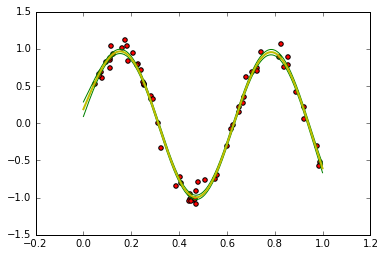

In [19]:
X_ = np.linspace(0, 1, 1000).reshape(-1, 1)
y_, var = gp.predict(X_)
plt.scatter(X, y, c='r')
plt.plot(X_, y_ + var**.5, c='g')
plt.plot(X_, y_ - var**.5, c='g')
plt.plot(X_, y_, c='y', linewidth=2)

### Higher Dimensions

In [ ]:
np.random.seed(45)
n = 1000
dim = 7
X = np.random.uniform(0, 1, (n, dim))
ls = [.1, .2, .4, .8, 1.6, 3.2, 6.4]
amp = 10.
noise = 0.001
sqdist = GP.compute_sqdist(X/ls)
K = amp**2 * np.exp(-0.5 * sqdist)
A = np.linalg.cholesky( K + np.eye(n)*1e-9 )
y = A.dot(np.random.randn(n, 1))

In [ ]:
shuffle = np.random.permutation(len(X))
X = X[shuffle]
y = y[shuffle]
mask = len(X)/3*2
X_train, y_train = X[:mask], y[:mask]
X_test, y_test = X[mask:], y[mask:]

In [ ]:
gp = GP(lsr=(.1, .2, 7),
       amp=1.,
       noise=1e-2)
gp.fit(X_train, y_train, 
       nepochs=500, batch_size=500, learning_rate=1e-2, 
       learning_rate_decay=.999, 
       verbose=2)
y_, var = gp.predict(X_train)
print "mse:", ((y_train - y_)**2).mean()/np.var(y_train)
y_, var = gp.predict(X_test)
print "mse:", ((y_test - y_)**2).mean()/np.var(y_test)
print "mse:", ((y_test - y_train.mean())**2).mean()/np.var(y_test)

In [ ]:
from sklearn.ensemble import RandomForestRegressor as RF

In [ ]:
rf = RF(n_estimators=1000).fit(X_train, np.squeeze(y_train))

y_ = rf.predict(X_train)
print "mse:", ((np.squeeze(y_train) - y_)**2).mean()/np.var(y_train)
y_ = rf.predict(X_test)
print "mse:", ((np.squeeze(y_test) - y_)**2).mean()/np.var(y_test)